In [1]:
# https://github.com/aaaquants/option-volatility-surface/blob/master/VolSurfacePlot.ipynb

import yfinance as yf
from dateutil.parser import parse
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
%matplotlib notebook
#from implied_vol import BlackScholes
from functools import partial
from scipy import optimize
import numpy as np
from scipy.interpolate import griddata
import pandas as pd

In [2]:
msft = yf.Ticker("MSFT")
msft.options
print("expiries. ", msft.options)
#print(opt.calls['volume']) # calls, count, index, puts
#print(expiry)

expiries.  ('2020-12-31', '2021-01-08', '2021-01-15', '2021-01-22', '2021-01-29', '2021-02-05', '2021-02-19', '2021-03-19', '2021-04-16', '2021-06-18', '2021-07-16', '2021-09-17', '2022-01-21', '2022-03-18', '2022-06-17', '2022-09-16', '2023-01-20')


In [3]:
lookback_days = 0
history = msft.history(period=str(lookback_days)+'d')['Close'] # make sure we have enough data

In [4]:
def CND(X):
 
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / np.sqrt(2*np.pi)*np.exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    
    if X<0:
        w = 1.0-w
 
    return w

def BlackScholes(v,CallPutFlag = 'c',S = 100.,X = 100.,T = 1.,r = 0.01):
 
    d1 = (np.log(S/X)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    
    if CallPutFlag=='c':
        return S*CND(d1)-X*np.exp(-r*T)*CND(d2)
 
    else:
        return X*np.exp(-r*T)*CND(-d2)-S*CND(-d1)

    
def calc_impl_vol(price = 5., right = 'c', underlying = 100., strike = 100., time = 1., rf = 0.0, inc = 0.001):
    
    def f(x):
        out = (BlackScholes(x,CallPutFlag=right,S=underlying,X=strike,T=time,r=rf)-price)**2 
        if x < 0.0:
            out += 1000.0 * (x)**2
        return out
  
    return optimize.minimize(f,x0=0.5, tol=1e-8, method='Nelder-Mead')

# List of points

In [5]:
data = []
rf = 0.0
rel_tol = 1e-8
# T, K/S, price/S
for mat in msft.options:
    opt = msft.option_chain(mat)
    calls = opt.calls
#    avg_volume = calls['volume'].mean()
    qtile = opt.calls['volume'].quantile(0.3)
    for (ind, contract) in calls.iterrows():
        if contract['volume'] <= qtile:
            continue
        lastTradeDate = pd.to_datetime(contract['lastTradeDate'].date())
        try:
            underlying = history.loc[lastTradeDate].unique()[0]
        except:
            continue
        strike = contract['strike']
        price = contract['lastPrice']
        tenor = (pd.to_datetime(mat)-lastTradeDate).ceil('D').days
#        tenor /= 365.0 # annualization
        tenor /= 252.0 # annualization
        res = calc_impl_vol(price = price, right = 'c', underlying = underlying, strike = strike, time = tenor, rf = rf)
        ivol = res.x[0]
        if ivol >= 0.6:
            continue
        price_iv = BlackScholes(ivol,CallPutFlag='c',S=underlying,X=strike,T=tenor,r=rf)
        rel_error = (price - price_iv)/price
        if abs(rel_error) >= rel_tol:
            continue
        else:
            data.append([tenor, strike/underlying, price/underlying, ivol, rel_error])

In [6]:
def plot3D(X,Y,Z,labels=None,title=None):
    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 40)
 
    ax.plot(X,Y,Z,'o')
      
    if labels is not None:
        if labels[0] is not None:
            ax.set_xlabel(labels[0])
        if labels[1] is not None:
            ax.set_ylabel(labels[1])
        if labels[2] is not None:
            ax.set_zlabel(labels[2])
    if title is not None:
        ax.set_title(title)
    plt.show()
    
def make_surf(X,Y,Z):
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),350),np.linspace(0.4,1.4,350))
#    XX,YY = np.meshgrid(np.linspace(min(X),max(X),350),np.linspace(min(Y),max(Y),350))
    ZZ = griddata(np.array([X,Y]).T,np.array(Z),(XX,YY))
    return XX,YY,ZZ

def mesh_plot2(X,Y,Z):
    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 40)
    XX,YY,ZZ = make_surf(X,Y,Z)

    ax.plot_surface(XX,YY,ZZ)
    ax.contour(XX,YY,ZZ)
    plt.xlabel("expiry")
    plt.ylabel("strike")
    plt.show()

<IPython.core.display.Javascript object>


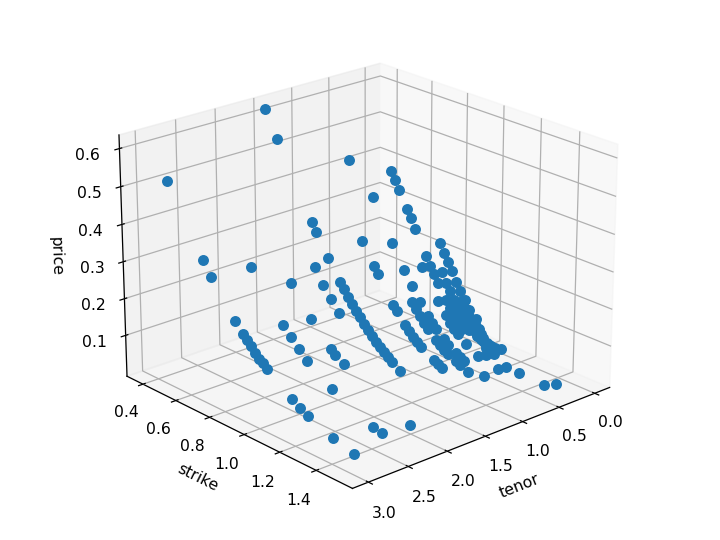

In [7]:
# Price surface
X,Y,Z = [],[],[]
for row in data:
    X.append(row[0])
    Y.append(row[1])
    Z.append(row[2])

plot3D(X,Y,Z,labels=['tenor','strike','price'],title='MSFT')

<IPython.core.display.Javascript object>


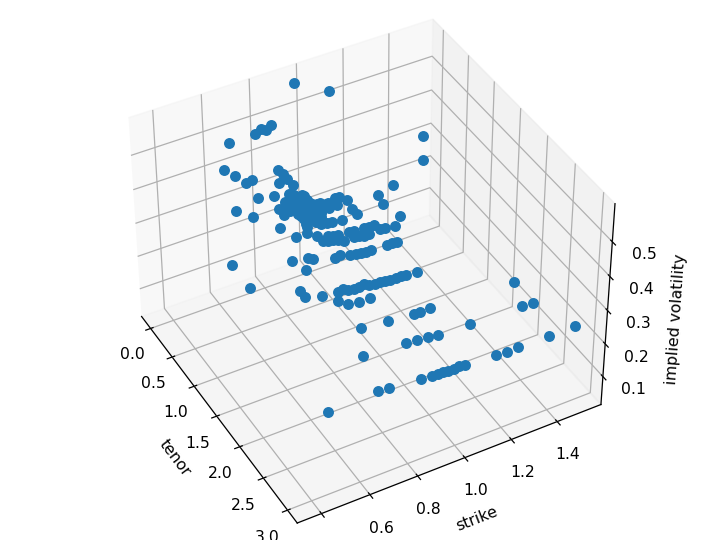

In [8]:
# Price surface
X,Y,Z = [],[],[]
for row in data:
    X.append(row[0])
    Y.append(row[1])
    Z.append(row[3])
    
plot3D(X,Y,Z,labels=['tenor','strike','implied volatility'],title='MSFT')

<IPython.core.display.Javascript object>


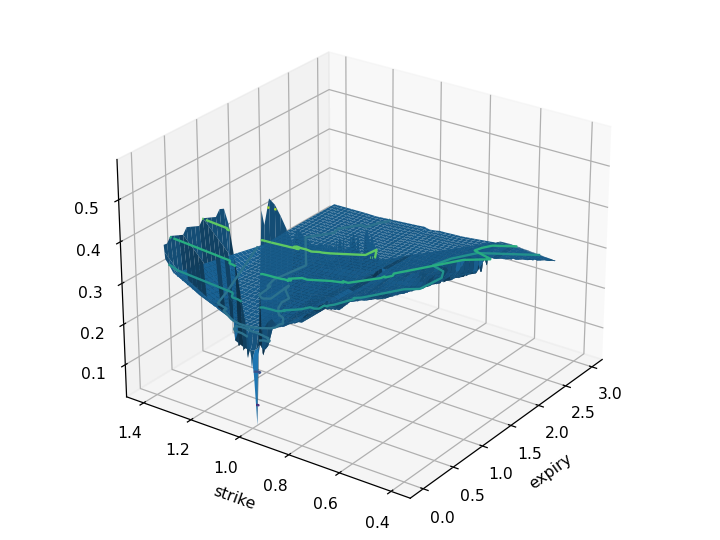

C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Z contains NaN values. This may result in rendering artifacts.


In [9]:
mesh_plot2(X,Y,Z)

<IPython.core.display.Javascript object>


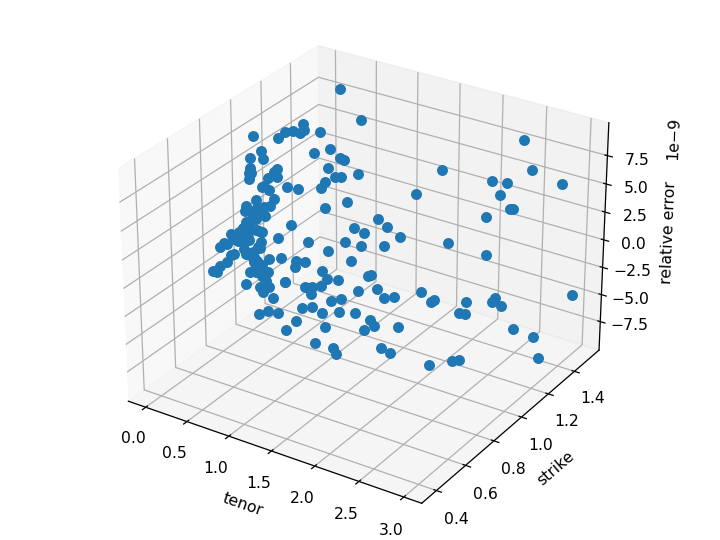

In [10]:
# Error surface
X,Y,Z = [],[],[]
for row in data:
    X.append(row[0])
    Y.append(row[1])
    Z.append(row[4])
    
plot3D(X,Y,Z,labels=['tenor','strike','relative error'],title='MSFT')

In [11]:
def get_surf(ticker):
    #q = get_opt_quote(ticker.upper())
    
    q = Options(ticker, 'yahoo').get_all_data() # error
    q.reset_index(inplace=True)
    q.set_index('Symbol',inplace=True)
    vals = []
    
    print(q.head())

    for index, row in q.iterrows():
        if row['Type'] == 'put':
            underlying = float(row['Underlying_Price'])
            price = (float(row['Ask'])+float(row['Bid']))/2.0
            expd = (row['Expiry'] - datetime.now()).days
            exps = (row['Expiry'] - datetime.now()).seconds
            exp = (expd*24.*3600. + exps) / (365.*24.*3600.)
            #print(price,'p',underlying,float(row['Strike']),exp)
            try:
                impl = calc_impl_vol(price, 'p', underlying, float(row['Strike']), exp)
                vals.append([exp,float(row['Strike']),impl])
                #print(impl)
            except:
                pass
            
    vals = array(vals).T
    plot3D(vals[0],vals[1],vals[2])
    #mesh_plot2(vals[0],vals[1],vals[2])

In [25]:
BlackScholes(0.317,CallPutFlag = 'c',S = 81000.,X = 80000.,T = 30/360,r = 0.0)

3464.8083941315053